<a href="https://colab.research.google.com/github/PGM-Lab/probai-2021-TAs/blob/main/Day2/notebooks/FA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Let's begin by installing and importing the modules we'll need.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy import special, stats
from scipy.stats import gamma
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
import pandas as pd

In [2]:
z_dim = 2
np.random.seed(1)

### DATA
DATA_URL = "https://raw.githubusercontent.com/PGM-Lab/probai-2021-pyro/main/Day2/prob_ai_data.csv"
data = pd.read_csv(DATA_URL).to_numpy()[:,1:]
num_cases = data.shape[0]
x_dim = data.shape[1]

gamma_shape = 1E-3
gamma_rate = 1E-3
theta_shape = 1E-3 * np.ones(x_dim)
theta_rate = 1E-3 * np.ones(x_dim)

### Display the data

In [3]:
display(data)
print(f"Data shape: {data.shape}")

array([[-0.30990786, -0.97921874,  1.21638084,  1.99395218,  4.16729373],
       [-0.28237305, -0.85110511,  1.10353218,  1.8818922 ,  3.87869654],
       [-0.25114087, -0.66846738,  0.97119527,  1.81388174,  3.6254771 ],
       ...,
       [ 0.30831946,  1.5583143 , -1.27799259, -1.05879966, -2.98570836],
       [ 0.31403247,  1.58902553, -1.30188648, -1.07551077, -3.0373844 ],
       [ 0.31589855,  1.59831978, -1.30960546, -1.08213649, -3.05572788]])

Data shape: (453, 5)


# Factor analysis

We will now analyze the data above using a factor analysis model. That is, we are interested in the representation of the data as conveyed by the latent variables in the model:

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day2/Figures/FA-model.png" alt="Drawing" width=800 >


## Variational model

We a variational approximation that factorizes as
$$
q({\bf w}, {\bf \theta}, {\bf z}, \gamma) = \prod_{j=1}^5q({\bf w}_j)q(\theta_j)\prod _{i=1}^{453}q(z_i)q(\gamma)
$$

## Helper routine: Caluclate ELBO

In [4]:
def evidence_lower_bound():

    elbo = 0

    # Entropy for...
    # ###############################

    # ... gamma:
    # Entropy contribution from gamma:
    # a - ln(b) +  ln(Gamma(a)) + (1-a) digamma(a)
    # a = shape, beta = rate
    # Calculate using scipy gamma distribution by
    #   1)  stats.gamma.entropy(a=q_gamma_shape) - np.log(q_gamma_rate)
    #   2)  stats.gamma.entropy(a=q_gamma_shape, scale=1. / q_gamma_rate)

    elbo += stats.gamma.entropy(a=q_gamma_shape, scale=1. / q_gamma_rate)

    # ... theta-vector:
    for j in range(x_dim):
        elbo += stats.gamma.entropy(a=q_theta_shape[j],
                                    scale=1. / q_theta_rate[j])

    # ... z
    for i in range(num_cases):
        elbo += stats.multivariate_normal.entropy(mean=q_z_matrix_mean[i, :], cov=q_z_matrix_covariance)

    # ... and w:
    for j in range(x_dim):
        elbo += stats.multivariate_normal.entropy(mean=q_w_matrix_mean[:, j],
                                                  cov=q_w_matrix_covariance[:, :, j])

    #
    # Log likelihood terms:
    # ##########################

    # log-likelihood term for Z is Gaussian shaped, with zero mean and I variance.
    # Expected Z'Z is equal to inv(prec) + EZ' EZ, which gives the contribution
    z_likelihood_contribution = - .5 * z_dim * num_cases * np.log(2 * np.pi) \
                                - .5 * np.sum(1.0 / np.diagonal(q_z_matrix_prec) + q_z_matrix_mean ** 2)
    elbo += z_likelihood_contribution

    # log-likelihood term gamma:
    # gamma = shape, beta = rate
    # a * log(b) - log-gamma(a) + (a-1)*E[log(X)] - b*E[x]
    # E[log(X)] = -ln(b) + digamma(a) ,  E[X] = a/b

    elbo += \
        gamma_shape * np.log(gamma_rate) - special.gammaln(gamma_shape) \
        + (gamma_shape - 1) * expected_log_gamma - gamma_rate * expected_gamma

    # log-likelihood term theta:
    # As for gamma, but remember we have a vector of length (x_dim)

    for j in range(x_dim):
        elbo += theta_shape[j] * np.log(theta_rate[j]) - special.gammaln(theta_shape[j]) + \
                (theta_shape[j] - 1) * expected_log_theta[j] \
                - theta_rate[j] * expected_theta[j]

    # log-likelihood term W is Gaussian shaped with mean 0 and prec gamma * I.
    #  Contribution from expected W^2 equal to inv(prec) + (EW)(EW)':
    # Now that Cov(W) is a full-dim matrix; the variational approximation has shape (z_dim, z_dim, x_dim).
    # We do the calculation as a loop over the x-dim:
    for j in range(x_dim):
        expected_w_square = np.sum(1.0 / np.diagonal(q_w_matrix_prec[:, :, j])
                                   + q_w_matrix_mean[:, j] ** 2)

        elbo += \
            - .5 * z_dim * np.log(2 * np.pi) \
            + .5 * z_dim * expected_log_gamma \
            - .5 * expected_w_square * expected_gamma

    # log likelihood term for x_ij is Gaussian shaped, with expected value w_j'z_i and
    # precision theta_j. Contribution to elbo is of type E[ (x_{ij} - w_j * z_i) ** 2  ].
    # This kernel is a bit tedious to calculate:
    x_likelihood_contribution = 0
    for i in range(num_cases):
        # z has dim (num_cases, z_dim)
        exp_z_z_transpose = np.matmul(q_z_matrix_mean[i, :].reshape([z_dim, 1]),
                                      q_z_matrix_mean[i, :].reshape([1, z_dim])) \
                            + q_z_matrix_covariance
        for j in range(x_dim):
            # z has dim (z_dim, x_dim)
            expected_w_w_transpose = np.matmul(q_w_matrix_mean[:, j].reshape([z_dim, 1]),
                                               q_w_matrix_mean[:, j].reshape([1, z_dim])) \
                                     + q_w_matrix_covariance[:, :, j]

            x_likelihood_contribution += \
                - .5 * np.log(2 * np.pi) \
                + .5 * expected_log_theta[j] \
                - .5 * expected_theta[j] * (
                        data[i, j] ** 2
                        - 2 * data[i, j] * np.matmul(q_z_matrix_mean[i, :], q_w_matrix_mean[:, j])
                        + np.trace(np.matmul(expected_w_w_transpose, exp_z_z_transpose)))

    elbo += x_likelihood_contribution

    return elbo


## Initialize the variational distributions

In [5]:
# Initialize the variational parameters
# Z: matrix of size [num_cases, z_dim]
# We will keep both variance and prec of Z explicitly
q_z_matrix_mean = np.random.normal(0, 1, (num_cases, z_dim))
q_z_matrix_prec = np.identity(n=z_dim)
q_z_matrix_covariance = np.identity(n=z_dim)

# W: matrix of size [z_dim, x_dim]
# We will keep both variance and prec of W explicitly
q_w_matrix_mean = np.random.normal(0, 1, (z_dim, x_dim))
q_w_matrix_prec = np.zeros((z_dim, z_dim, x_dim))
q_w_matrix_covariance = np.zeros((z_dim, z_dim, x_dim))
for j in range(z_dim):
    q_w_matrix_prec[j, j, :] = 1.
    q_w_matrix_covariance[j, j, :] = 1.

# gamma: Scalar
q_gamma_shape = 1
q_gamma_rate = 1
# We also calculate some expected values to be used during updating
expected_gamma = q_gamma_shape / q_gamma_rate
expected_log_gamma = - np.log(q_gamma_rate) + special.digamma(q_gamma_shape)

# Theta: Vector size [x_dim]
q_theta_shape = np.ones(x_dim)
q_theta_rate = np.ones(x_dim)
# We also calculate some expected values to be used during updating
expected_theta = q_theta_shape / q_theta_rate
expected_log_theta = - np.log(q_theta_rate) + special.digamma(q_theta_shape)


## Updating rules for the variational distributions

Note that only two if the updating rules are given in the slides

In [6]:
def update_gamma():
    q_gamma_shape = gamma_shape + .5 * z_dim * x_dim
    sum_squared = 0
    for j in range(x_dim):
        sum_squared += np.sum(1. / np.diagonal(q_w_matrix_prec[:, :, j]) +
                              q_w_matrix_mean[:, j] ** 2)
    q_gamma_rate = gamma_rate + 0.5 * sum_squared

    expected_gamma = q_gamma_shape / q_gamma_rate
    expected_log_gamma = - np.log(q_gamma_rate) + special.digamma(q_gamma_shape)
    
    return q_gamma_shape, q_gamma_rate, expected_gamma, expected_log_gamma

In [7]:
def update_z_matrix():

    # Z is a matrix of shape [num_cases, z_dim].
    # We will update Z_i one by one, where i is the first index  -- over observations
    # Theta is a vector of length x_dim, unexplained noise for X_{*, j} -- the j'th attribute
    # W is a matrix of shape [z_dim, x_dim]
    # We will consider each W[*, j] in turn. It is a vector of length z-dim

    # Update rules: Z remains Gaussian, precision and mean as given below

    # First calculate precision.
    # Q_i = I + \sum_j E[theta_j] * E [W_j * W_j']
    # Notice how it is the same for all i, hence do this once
    # Expand the sum over j explicitly
    # We will keep the full precision matrix (inverse covariance) over Z_i -- it has shape [z_dim, z_dim]
    new_prec = np.identity(n=z_dim)
    for j in range(x_dim):
        expected_w_j_w_j_transpose = q_w_matrix_covariance[:, :, j] + \
                                     np.matmul(q_w_matrix_mean[:, j].reshape((z_dim, 1)),
                                               q_w_matrix_mean[:, j].reshape((1, z_dim)))
        new_prec += expected_theta[j] * expected_w_j_w_j_transpose

    q_z_matrix_prec = new_prec
    q_z_matrix_covariance = np.linalg.inv(new_prec)

    # mean_i = Q_i^{-1} * sum_{j} x_ij * + E[theta_j] *  E[W_j]
    for i in range(num_cases):
        new_mean = 0
        for j in range(x_dim):
            new_mean += data[i, j] * expected_theta[j] * q_w_matrix_mean[:, j]
        new_mean = np.matmul(q_z_matrix_covariance, new_mean)
        q_z_matrix_mean[i, :] = new_mean
    
    return q_z_matrix_prec, q_z_matrix_covariance, q_z_matrix_mean 

In [8]:
def update_w_matrix():

    # W is a matrix of shape [z_dim, x_dim].
    # Theta is a vector of length x_dim, unexplained noise for X_{*, j} -- the j'th attribute
    # Gamma is a scalar -- the prior variance for each and every W-entry
    # Z is a matrix of shape [num_cases, z_dim]
    # It has variational expectation q_z_matrix_mean with shape  [num_cases, z_dim] and
    # variational precision q_z_matrix_prec. The prec has shape [z_dim, z_dim] as we take care of the full
    # covariance, and utilize that all precisions (for each observation) is the same for each observation.
    # We will update W[:, j] one by one, where j is the second index  -- over attributes for the observation

    # Update rules: W remains Gaussian, precision and mean as given below

    # First calculate precision.
    # Q_j = E[gamma] * I + E[theta_j] *  \sum_i  E [Z_i * Z_i']
    # In contrast to the result for Z_i, this one is *not* the same for each j.

    sum_expected_square_z = num_cases * q_z_matrix_covariance
    for i in range(num_cases):
        sum_expected_square_z += np.matmul(q_z_matrix_mean[i, :].reshape((z_dim, 1)),
                                           q_z_matrix_mean[i, :].reshape((1, z_dim)))

    for j in range(x_dim):
        q_w_matrix_prec[:, :, j] = expected_gamma * np.identity(n=z_dim) + \
                                        expected_theta[j] * sum_expected_square_z
        q_w_matrix_covariance[:, :, j] = np.linalg.inv(q_w_matrix_prec[:, :, j])

    # mean_j = Q_j^{-1} *  E[theta_j] sum_{i} x_ij * E[Z_i]
    for j in range(z_dim):
        weighted_sum_latent = np.matmul(np.transpose(data[:, j]), q_z_matrix_mean)
        q_w_matrix_mean[:, j] = \
            expected_theta[j] * np.matmul(q_w_matrix_covariance[:, :, j], weighted_sum_latent)
        
    return q_w_matrix_prec, q_w_matrix_covariance, q_w_matrix_mean 

In [9]:
def update_theta():
    # Theta is a vector of length (x-dim)
    # Theta_j is the unexplained precision for attribute j.
    # Remember shapes:
    #   W is a matrix of shape [z_dim, x_dim].
    #   Z is a matrix of shape [num_cases, z_dim]
    #   data is a matrix of shape [num_cases, x_dim]
    #
    # Update rule: Remains Gamma distributed.
    #
    # Shape <- a  + num_cases / 2 -- for all j
    new_shape = theta_shape + .5 * num_cases
    q_theta_shape = new_shape

    # Rate[j] <- b[j] + .5 * sum_i E{ [x_ij - w_j\trans z_i]**2 }
    # The elements in the sum can be expanded as
    #       x_ij ** 2 - 2 * x_ij * E[W_j]\trans E[Z_i] + trace( E(W_j W_j') * E(Z_i Z_i') )

    for j in range(x_dim):
        # W has dim (z_dim, x_dim)
        # exp_w_w_transpose picks out for one j W_j of shape [z_dim], and
        # calculates the matrix Exp[W_j W_j\trans ].
        # This is Exp[W_j]*E[W_j]\trans + Variance elements
        exp_w_w_transpose = np.matmul(q_w_matrix_mean[:, j].reshape([z_dim, 1]),
                                      q_w_matrix_mean[:, j].reshape([1, z_dim])) \
                            + q_w_matrix_covariance[:, :, j]

        sum_of_squared_offsets = 0
        # Z has dim (num_cases, z_dim). Do same operation as above to find Exp[Z_i Z_i\trans ]
        # Afterwards, both these matrices are of shape [z_dim, z_dim and we can multiply them together]
        for i in range(num_cases):
            exp_z_square = np.matmul(q_z_matrix_mean[i, :].reshape([z_dim, 1]),
                                     q_z_matrix_mean[i, :].reshape([1, z_dim])) \
                           + q_z_matrix_covariance
            sum_of_squared_offsets += \
                data[i, j] ** 2 \
                - 2 * data[i, j] * np.matmul(q_z_matrix_mean[i, :], q_w_matrix_mean[:, j]) \
                + np.trace(np.matmul(exp_w_w_transpose, exp_z_square))

        q_theta_rate[j] = theta_rate[j] + .5 * sum_of_squared_offsets

    expected_theta = q_theta_shape / q_theta_rate
    expected_log_theta = - np.log(q_theta_rate) + special.digamma(q_theta_shape)
    
    return q_theta_shape, q_theta_rate, expected_theta, expected_log_theta

## Inference

In [10]:
old_elbo = new_elbo = -np.infty
num_iter = 100
elbo_values = []
for iteration in range(num_iter):

    # Doing Z:
    q_z_matrix_prec, q_z_matrix_covariance, q_z_matrix_mean = update_z_matrix()
  
    # Doing W:
    q_w_matrix_prec, q_w_matrix_covariance, q_w_matrix_mean =update_w_matrix()
  
    # Theta:
    q_theta_shape, q_theta_rate, expected_theta, expected_log_theta = update_theta()
  
    # Gamma:
    q_gamma_shape, q_gamma_rate, expected_gamma, expected_log_gamma = update_gamma()
  
    new_elbo = evidence_lower_bound()   # Check if we are done
    if iteration > 1 and abs((new_elbo - elbo_values[-1]) / new_elbo) < - 1E-8:
        # No need to go on
        break

    if iteration % 10 == 0:
        print(f"ELBO at iteration {iteration:3}: {new_elbo}")
        
    # Remember the new elbo value for nice plots
    elbo_values.append(new_elbo)
    old_elbo = new_elbo

ELBO at iteration   0: -3089.114119670793
ELBO at iteration  10: -828.434173086067
ELBO at iteration  20: -116.91890211061445
ELBO at iteration  30: -3.098158349325786
ELBO at iteration  40: 9.69000352159128
ELBO at iteration  50: 15.196258443297666
ELBO at iteration  60: 20.288189635618437
ELBO at iteration  70: 25.44764327111352
ELBO at iteration  80: 30.721041555706506
ELBO at iteration  90: 36.11940159424921


### Plot the evolution in the ELBO values

Text(0, 0.5, 'ELBO')

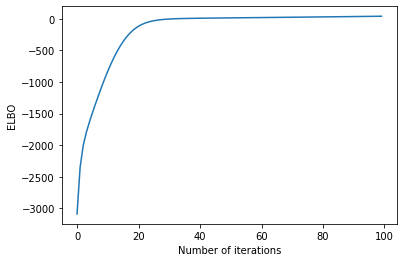

In [11]:
plt.plot(range(num_iter), elbo_values)
plt.xlabel('Number of iterations')
plt.ylabel("ELBO")

### Investigate the latent representarion of the data

In [12]:
# We have a 2-dimensional latent space, which we can visualize (in this case we only consider the mean values)
x, y= zip(*q_z_matrix_mean)

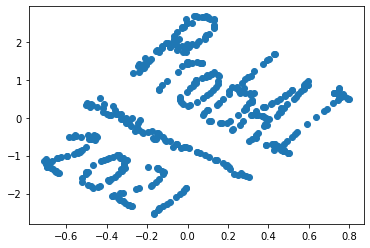

In [13]:
plt.scatter(x,y)